In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sb

from pathlib import Path

from lola.plot import draw

os.environ["PATH"] += ":/mnt/sw/nix/store/80wb60hk9c9hbi1rzbnr6kdbbjknp4ch-texlive-20220321/bin/x86_64-linux"

outdir = Path("./figures")
outdir.mkdir(exist_ok=True)

rc = {
    "axes.axisbelow": True,
    "axes.linewidth": 1.0,
    "axes.labelsize": "x-small",
    "axes.titlesize": "x-small",
    "figure.dpi": 150,
    "figure.figsize": (3.2, 3.2),
    "font.size": 12.0,
    "legend.fontsize": "xx-small",
    "lines.linewidth": 1.0,
    "savefig.transparent": True,
    "xtick.labelsize": "xx-small",
    "xtick.major.width": 1.0,
    "ytick.labelsize": "xx-small",
    "ytick.major.width": 1.0,
    "font.family": ["serif"],
    "text.usetex": True,
    "text.latex.preamble": r"\usepackage{amsfonts}",
}

plt.rcParams.update(rc)

In [2]:
settings = "mean_absolute"

## Dataframe

In [3]:
df = pd.read_csv(
    "~/ceph/lola/results/euler_all/stats.csv",
    names=[
        "run",
        "target",
        "compression",
        "method",
        "settings",
        "guidance",
        "context",
        "overlap",
        "speed",
        "split",
        "index",
        "start",
        "seed",
        "field",
        "time",
        "relative",
        "m1",
        "m2",
        "spread",
        "rmse",
        "nrmse",
        "vrmse",
        "re_total",
        "wasserstein",
        "emd",
        "rmse_p_low",
        "rmse_c_low",
        "rmse_p_mid",
        "rmse_c_mid",
        "rmse_p_high",
        "rmse_c_high",
        "rmse_p_sub",
        "rmse_c_sub",
        "gamma",
        "bc00",
        "bc01",
        "bc10",
        "bc11",
    ],
    dtype={"settings": str, "guidance": str, "compression": int},
)

if "relative" in settings:
    df = df[df["relative"]]
elif "absolute" in settings:
    df = df[~df["relative"]]

df = df[df["time"] > 0]
df = df.sort_values(["method", "compression"], kind="stable")
df = df.merge(
    pd.DataFrame({
        "field": [0, 1, 2, 3, 4],
        "std_global": [0.55, 0.25, 0.30, 0.50, 0.50],
    })
)


def horizon(t):
    if t < 20:
        return "01:20"
    elif t < 60:
        return "21:60"
    else:
        return "61:100"


df["horizon"] = df["time"].apply(horizon)
df["std_instant"] = np.sqrt(df["m2"] - df["m1"] ** 2)
df["spread_skill"] = (df["spread"] + 1e-3) / (df["rmse"] + 1e-3)
df["method"] = df["method"].replace("surrogate", "neural solver")
df.loc[df["method"] == "neural solver", "spread_skill"] = 0.0

In [4]:
def aggregate(x):
    if "mean" in settings:
        return np.mean(x)
    elif "median" in settings:
        return np.median(x)

### Plots

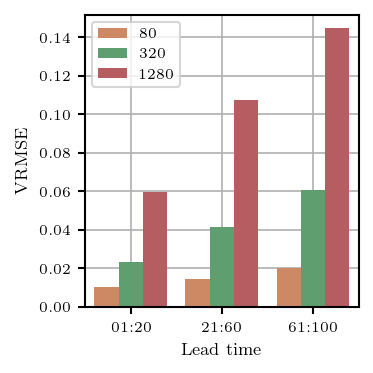

In [5]:
table = df[df["method"] == "autoencoder"]

fig = plt.figure(figsize=(2.4, 2.4))

ax = sb.barplot(
    table,
    x="horizon",
    y="vrmse",
    hue="compression",
    estimator=aggregate,
    errorbar=None,
    palette=sb.color_palette("deep", 4)[1:],
)

ax.grid()
ax.get_legend().set_title(None)

ax.set_xlabel("Lead time")
ax.set_ylabel("VRMSE")

fig.tight_layout(pad=0.33)

plt.savefig(outdir / f"euler_ae_{settings}.pdf", dpi=300, transparent=True)

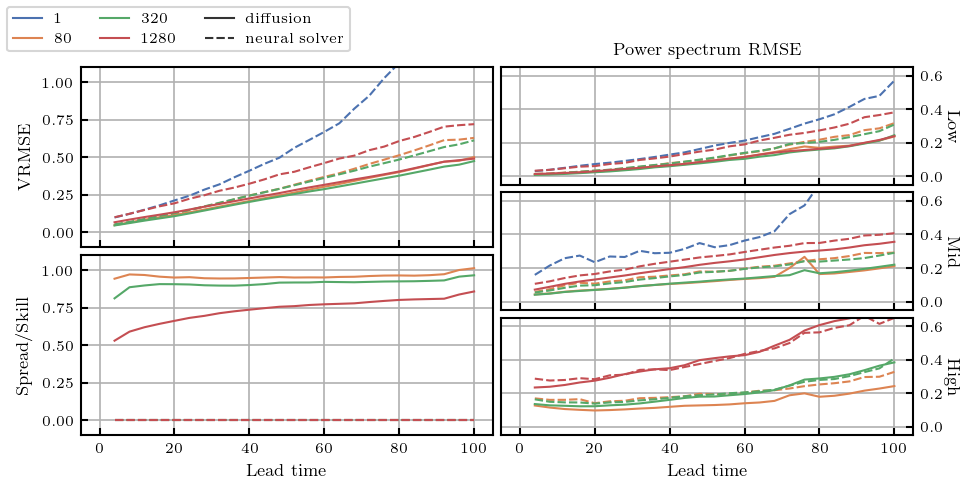

In [6]:
table = df[df["method"] != "autoencoder"]

fig, axs = plt.subplot_mosaic(
    [
        [0, 2],
        [0, 2],
        [0, 3],
        [1, 3],
        [1, 4],
        [1, 4],
    ],
    figsize=(6.4, 3.2),
    sharex=True,
    sharey=False,
)

for i, metric in enumerate(["VRMSE", "spread_skill"]):
    ax = sb.lineplot(
        table,
        x="time",
        y=metric.lower(),
        hue="compression",
        style="method",
        estimator=aggregate,
        errorbar=None,
        palette=sb.color_palette("deep", 4),
        ax=axs[i],
    )

    ax.get_legend().remove()
    ax.grid()

    ax.set_xlabel("Lead time")
    ax.set_xlim(-5, 105)
    ax.set_ylim(-0.1, 1.1)

    if metric == "spread_skill":
        ax.set_ylabel("Spread/Skill")
    else:
        ax.set_ylabel(metric)

    ax.tick_params(direction="in")

    handles, labels = ax.get_legend_handles_labels()

for i, band in enumerate(["Low", "Mid", "High"], start=2):
    ax = sb.lineplot(
        table,
        x="time",
        y=f"rmse_p_{band.lower()}",
        hue="compression",
        style="method",
        estimator=aggregate,
        errorbar=None,
        palette=sb.color_palette("deep", 4),
        ax=axs[i],
    )

    ax.get_legend().remove()
    ax.grid()

    ax.set_xlabel("Lead time")
    ax.set_xlim(-5, 105)

    ax.set_ylabel(band)
    ax.set_ylim(-0.05, 0.65)

    ax.tick_params(direction="in")

    ax.yaxis.set_label_position("right")
    ax.yaxis.label.set(rotation=-90, va="center")
    ax.yaxis.tick_right()

    if i == 2:
        ax.set_title("Power spectrum RMSE")

for i, label in reversed(list(enumerate(labels))):
    if label in ("compression", "method"):
        blank = handles.pop(i)
        labels.pop(i)

fig.align_labels()
fig.tight_layout(pad=0.33)
fig.subplots_adjust(top=0.875)
fig.legend(handles, labels, loc="upper left", ncol=3)

plt.savefig(outdir / f"euler_mosaic_{settings}.pdf", dpi=300, transparent=True)

## Tables

In [7]:
table = df[["method", "compression", "horizon", "vrmse"]]

table = table.groupby(["method", "compression", "horizon"]).agg(aggregate).round(3).reset_index()
table = table.pivot(index=["method", "compression"], columns="horizon", values=["vrmse"])
# print(table.to_latex(float_format="%.3f"))
table

vrmse              
horizon                    01:20  21:60 61:100
method        compression                     
autoencoder   80           0.011  0.014  0.020
              320          0.023  0.041  0.061
              1280         0.060  0.107  0.144
diffusion     80           0.075  0.199  0.395
              320          0.070  0.192  0.371
              1280         0.093  0.217  0.400
neural solver 1            0.138  0.397  1.102
              80           0.077  0.232  0.500
              320          0.080  0.232  0.476
              1280         0.137  0.314  0.592

In [8]:
table = df[(df["method"] != "autoencoder") & (df["compression"] > 1)]
table = table[["method", "context", "horizon", "vrmse"]]

table = table.groupby(["method", "context", "horizon"]).agg(aggregate).round(3).reset_index()
table = table.pivot(index=["method", "context"], columns="horizon", values=["vrmse"])
# print(table.to_latex(float_format="%.3f"))
table

vrmse              
horizon                01:20  21:60 61:100
method        context                     
diffusion     1        0.085  0.204  0.393
              2        0.075  0.200  0.383
              3        0.078  0.203  0.389
neural solver 1        0.108  0.266  0.526
              2        0.092  0.253  0.513
              3        0.094  0.260  0.529

In [9]:
table = df[["method", "compression", "horizon", "rmse_p_low", "rmse_p_mid", "rmse_p_high"]]

table = table.groupby(["method", "compression", "horizon"]).agg(aggregate).round(3).reset_index()
table = table.pivot(
    index=["method", "compression"],
    columns="horizon",
    values=["rmse_p_low", "rmse_p_mid", "rmse_p_high"],
)
# print(table.to_latex(float_format="%.3f"))
table

rmse_p_low               rmse_p_mid                \
horizon                        01:20  21:60 61:100      01:20  21:60 61:100   
method        compression                                                     
autoencoder   80               0.001  0.001  0.001      0.006  0.008  0.014   
              320              0.002  0.003  0.004      0.022  0.047  0.085   
              1280             0.009  0.017  0.025      0.074  0.167  0.264   
diffusion     80               0.017  0.063  0.168      0.054  0.100  0.178   
              320              0.014  0.058  0.157      0.052  0.101  0.171   
              1280             0.019  0.065  0.163      0.096  0.187  0.300   
neural solver 1                0.046  0.128  0.339      0.227  0.297  0.754   
              80               0.021  0.074  0.212      0.085  0.151  0.245   
              320              0.020  0.075  0.204      0.074  0.144  0.234   
              1280             0.045  0.116  0.274      0.131  0.227  0.349   

                          rmse_p_high                
horizon                         01:20  21:60 61:100  
method        compression                            
autoencoder   80                0.072  0.069  0.096  
              320               0.112  0.141  0.240  
              1280              0.240  0.355  0.577  
diffusion     80                0.112  0.116  0.184  
              320               0.128  0.155  0.275  
              1280              0.246  0.349  0.569  
neural solver 1                 0.821  0.984  2.666  
              80                0.164  0.173  0.249  
              320               0.151  0.169  0.271  
              1280              0.283  0.345  0.545

In [10]:
table = df[df["field"] == 1]  # density
table = table[["method", "compression", "horizon", "emd"]]

table = table.groupby(["method", "compression", "horizon"]).agg(aggregate).round(4).reset_index()
table = table.pivot(index=["method", "compression"], columns="horizon", values=["emd"])
# print(table.to_latex(float_format="%.3f"))
table

emd                
horizon                     01:20   21:60  61:100
method        compression                        
autoencoder   80           0.0000  0.0000  0.0000
              320          0.0001  0.0001  0.0001
              1280         0.0002  0.0003  0.0005
diffusion     80           0.0004  0.0010  0.0023
              320          0.0003  0.0009  0.0022
              1280         0.0004  0.0010  0.0023
neural solver 1            0.0011  0.0031  0.0066
              80           0.0005  0.0012  0.0028
              320          0.0004  0.0012  0.0027
              1280         0.0008  0.0020  0.0041

## Images

In [11]:
path = Path("~/ceph/lola/videos/euler_all")
path = path.expanduser()

runs = df[["run", "method", "compression"]]
runs = runs.drop_duplicates()

field = 1
frames = np.array([5, 15, 25])

for run, method, compression in runs.values:
    files = (path / run).glob("*.npz")
    files = sorted(files)

    for i, file in enumerate(files):
        x, x_hat = np.load(file).values()

        x = x[field, frames, ::2, ::2]
        x_hat = x_hat[:, field, frames, ::2, ::2]

        vmin = np.nanquantile(x, 0.01, keepdims=True) - 1e-2
        vmax = np.nanquantile(x, 0.99, keepdims=True) + 1e-2

        draw(x, vmin=vmin, vmax=vmax, pad=8).save(outdir / f"euler_{i}_gt.png")

        for j in range(len(x_hat)):
            draw(x_hat[j], vmin=vmin, vmax=vmax, pad=8).save(outdir / f"euler_{i}_{method}_{compression:04d}_{j}.png")